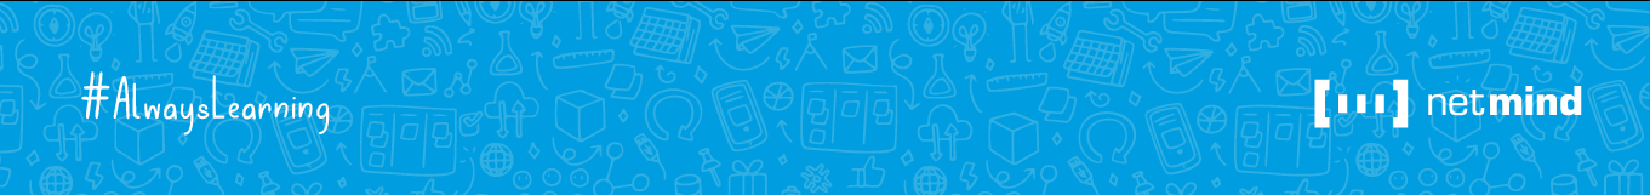
# **Ajuste de hiperparámetros**

En Azure Machine Learning, puede ajustar hiperparámetros mediante el envío de un script como un job de barrido. 
- Ejecutará una prueba para cada combinación de hiperparámetros a probar. 
- Cada prueba usa un script con valores de hiperparámetros para entrenar un modelo y registra la métrica de rendimiento objetivo lograda por el modelo entrenado.

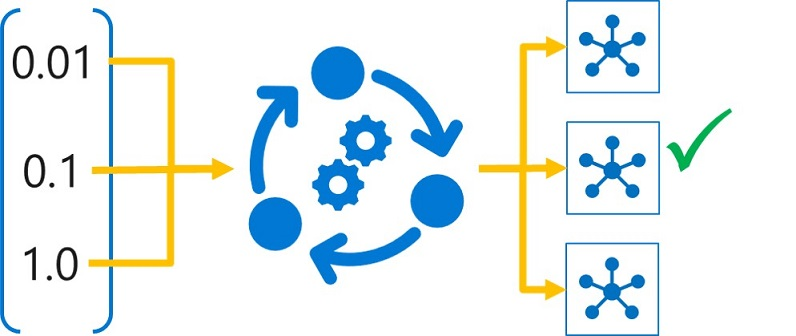


https://learn.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters?view=azureml-api-2

## **Definición de un espacio de búsqueda**

El conjunto de valores de hiperparámetros probados durante el ajuste de hiperparámetros se conoce como el espacio de búsqueda. 

La definición del intervalo de valores posibles que se puede elegir depende del tipo de hiperparámetros.

### Hiperparámetros discretos
Se puede definir un espacio de búsqueda para un parámetro discreto mediante **Choice** de una lista de valores explícitos, que puede definir como:
- una lista de de Python (Choice(values=[10,20,30]))
- un intervalo (Choice(values=range(1,10))) o un conjunto arbitrario de valores separados por comas (Choice(values=(30,50,100)))

También puede seleccionar valores discretos de cualquiera de las siguientes distribuciones discretas:

- `QUniform(min_value, max_value, q)`: devuelve un valor como round(Uniform(min_value, max_value) / q) * q
- `QLogUniform(min_value, max_value, q)`: Devuelve un valor como round(exp(Uniform(min_value, max_value)) / q) * q
- `QNormal(mu, sigma, q)`: devuelve un valor como round(Normal(mu, sigma) / q) * q
- `QLogNormal(mu, sigma, q)`: devuelve un valor como round(exp(normal(mu, sigma)) / q) * q)

### Hiperparámetros continuos
Para definir un espacio de búsqueda para estos tipos de valor, puede usar cualquiera de los siguientes tipos de distribución:

- `Uniform(min_value, max_value)`: devuelve un valor distribuido uniformemente entre min_value y max_value
- `LogUniform(min_value, max_value)`: devuelve un valor dibujado según exp(Uniform(min_value, max_value)) para que el logaritmo del valor devuelto se distribuya uniformemente.
- `Normal(mu, sigma)`: devuelve un valor real que sigue una distribución normal con media µ y desviación estándar sigma.
- `LogNormal(mu, sigma)`: devuelve un valor dibujado según exp(Normal(mu, sigma)) para que el logaritmo del valor devuelto se distribuya normalmente.

### Definición de un espacio de búsqueda
Crear un diccionario con la expresión de parámetro adecuada para cada hiperparámetro nombrado.

Por ejemplo, el siguiente espacio de búsqueda indica que el batch_size hiperparámetros puede tener el valor 16, 32 o 64, y el learning_rate hiperparámetros puede tener cualquier valor de una distribución normal con una media de 10 y una desviación estándar de 3.

In [ ]:
from azure.ai.ml.sweep import Choice, Normal

command_job_for_sweep = job(
    batch_size=Choice(values=[16, 32, 64]),    
    learning_rate=Normal(mu=10, sigma=3),
)

## **Configuración de un método de muestreo**
Los valores específicos que se usan en una ejecución de ajuste de hiperparámetros, o trabajo de barrido, dependen del tipo de muestreo que se usa.

Hay tres métodos de muestreo principales disponibles en Azure Machine Learning:

- **Muestreo de cuadrícula**: prueba todas las combinaciones posibles.
- **Muestreo aleatorio**: elige aleatoriamente los valores del espacio de búsqueda.
    - **Sobol**: agrega un valor de inicialización al muestreo aleatorio para que los resultados sean reproducibles.
- **Muestreo bayesiano**: elige nuevos valores en función de los resultados anteriores.

In [ ]:
# Muestreo de cuadrícula

from azure.ai.ml.sweep import Choice

command_job_for_sweep = command_job(
    batch_size=Choice(values=[16, 32, 64]),
    learning_rate=Choice(values=[0.01, 0.1, 1.0]),
)

sweep_job = command_job_for_sweep.sweep(
    sampling_algorithm = "grid",
    ...
)

In [ ]:
# Muestreo aleatorio
from azure.ai.ml.sweep import Normal, Uniform

command_job_for_sweep = command_job(
    batch_size=Choice(values=[16, 32, 64]),   
    learning_rate=Normal(mu=10, sigma=3),
)

sweep_job = command_job_for_sweep.sweep(
    sampling_algorithm = "random",
    ...
)

In [ ]:
# Sobol
from azure.ai.ml.sweep import RandomSamplingAlgorithm

sweep_job = command_job_for_sweep.sweep(
    sampling_algorithm = RandomSamplingAlgorithm(seed=123, rule="sobol"),
    ...
)

In [ ]:
# Muestreo bayesiano
from azure.ai.ml.sweep import Uniform, Choice

command_job_for_sweep = job(
    batch_size=Choice(values=[16, 32, 64]),    
    learning_rate=Uniform(min_value=0.05, max_value=0.1),
)

sweep_job = command_job_for_sweep.sweep(
    sampling_algorithm = "bayesian",
    ...
)

## **Configuración de la terminación anticipada**
Encontrar el mejor modelo puede ser una conquista interminable. Siempre debe tener en cuenta si vale la pena el tiempo y el gasto de probar nuevos valores de hiperparámetros para encontrar un modelo que pueda funcionar mejor.
- Si el entrenamiento de un nuevo modelo no da como resultado un modelo significativamente mejor, es posible que quiera detener el trabajo de barrido y usar el modelo que mejor funcionó hasta el momento.

Al configurar un trabajo de barrido en Azure Machine Learning, también se puede establecer un número máximo de pruebas. 
- Un enfoque más sofisticado puede ser detener un trabajo de barrido cuando los nuevos modelos no producen resultados significativamente mejores. 

Para detener un trabajo de barrido en función del rendimiento de los modelos, puede usar una directiva de terminación anticipada.

### Configuración de una directiva de terminación anticipada
Hay dos parámetros principales al elegir usar una directiva de terminación anticipada:

- `evaluation_interval`: especifica en qué intervalo desea evaluar la directiva. Cada vez que se registra la métrica principal para una prueba cuenta como un intervalo.
- `delay_evaluation`: especifica cuándo empezar a evaluar la directiva. Este parámetro permite que se completen al menos un mínimo de pruebas sin una directiva de terminación anticipada que les afecte.

Es posible que los nuevos modelos sigan funcionando solo ligeramente mejor que los anteriores. Para determinar la medida en que un modelo debe funcionar mejor que las pruebas anteriores, hay tres opciones para la terminación anticipada:

- **Directiva bandido**: usa un slack_factor (relativo) o slack_amount (absoluto). Cualquier modelo nuevo debe funcionar dentro del rango de holgura del modelo de mejor rendimiento.
- **Directiva de detención de mediana**: usa la mediana de los promedios de la métrica principal. Cualquier nuevo modelo debe funcionar mejor que la mediana.
- **Directiva de selección de truncamiento**: usa un truncation_percentage, que es el porcentaje de pruebas con menor rendimiento. Cualquier modelo nuevo debe funcionar mejor que las pruebas de menor rendimiento.


### Directiva bandido
Imagina que la métrica principal es la precisión del modelo. 
- Cuando, después de las cinco primeras pruebas, el modelo que mejor funciona tiene una precisión de 0,9, cualquier modelo nuevo tiene que funcionar mejor que (0,9-0,2) o 0,7. 
- Si la precisión del nuevo modelo es superior a 0,7, el trabajo de barrido continuará. 
- Si el nuevo modelo tiene una puntuación de precisión inferior a 0,7, la directiva finalizará el trabajo de barrido.


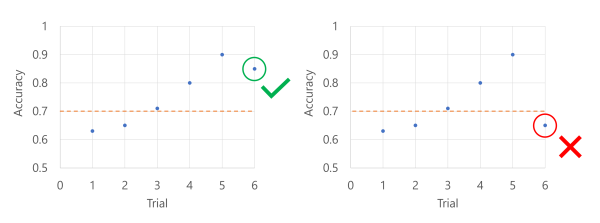

In [ ]:
# Directiva bandido

from azure.ai.ml.sweep import BanditPolicy

sweep_job.early_termination = BanditPolicy(
    slack_amount = 0.2, 
    delay_evaluation = 5, 
    evaluation_interval = 1
)

### Directiva de detención de mediana 

Abandona las pruebas cuando la métrica de rendimiento de destino es inferior a la mediana del promedio de ejecuciones para todas las pruebas.

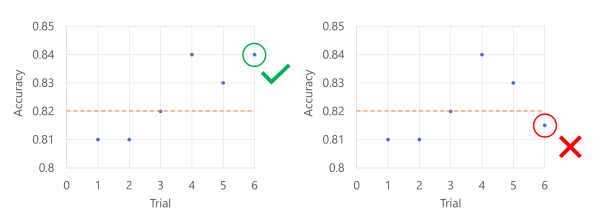

In [ ]:
from azure.ai.ml.sweep import MedianStoppingPolicy

sweep_job.early_termination = MedianStoppingPolicy(
    delay_evaluation = 5, 
    evaluation_interval = 1
)

### Directiva de selección de truncamiento
Cancela el X % de ejecuciones con menor rendimiento en cada intervalo de evaluación en función del valor de truncation_percentage que especificó para X.

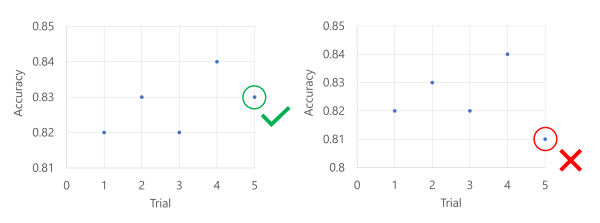

In [ ]:
from azure.ai.ml.sweep import TruncationSelectionPolicy

sweep_job.early_termination = TruncationSelectionPolicy(
    evaluation_interval=1, 
    truncation_percentage=20, 
    delay_evaluation=4 
)

## **Usar un proceso de barrido para el ajuste de hiperparámetros**

Para ejecutar un trabajo de barrido, se debe crear un script de entrenamiento tal como lo haría para cualquier otro trabajo de entrenamiento:
- Incluir un argumento para cada hiperparámetros que desee variar.
- Registrar la métrica de rendimiento de destino con MLflow. Una métrica registrada permite al trabajo de barrido evaluar el rendimiento de las pruebas que inicia e identificar el que genera el modelo de mejor rendimiento.

**Ejemplo**:  el siguiente script de ejemplo entrena un modelo de regresión logística mediante un argumento `--regularization` para establecer el hiperparámetro de tasa de regularización y registra el métrica de precisión con el nombre `Accuracy`.

In [ ]:
import argparse
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import mlflow

# get regularization hyperparameter
parser = argparse.ArgumentParser()
parser.add_argument('--regularization', type=float, dest='reg_rate', default=0.01)
args = parser.parse_args()
reg = args.reg_rate

# load the training dataset
data = pd.read_csv("data.csv")

# separate features and labels, and split for training/validatiom
X = data[['feature1','feature2','feature3','feature4']].values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

# train a logistic regression model with the reg hyperparameter
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

# calculate and log accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
mlflow.log_metric("Accuracy", acc)

### Configurar y ejecutar un trabajo de barrido

In [ ]:
from azure.ai.ml import command

# Configurar el trabajo de comando como base
job = command(
    code="./src",
    command="python train.py --regularization ${{inputs.reg_rate}}",
    inputs={
        "reg_rate": 0.01,
    },
    environment="AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest",
    compute="aml-cluster",
    )

In [ ]:
# sobreescribir los parámetros de entrada con el espacio de búsqueda:
from azure.ai.ml.sweep import Choice

command_job_for_sweep = job(
    reg_rate=Choice(values=[0.01, 0.1, 1]),
)

In [ ]:
# ejecutar sweep() en su tarea de comando para barrer el espacio de búsqueda.
from azure.ai.ml import MLClient

# apply the sweep parameter to obtain the sweep_job
sweep_job = command_job_for_sweep.sweep(
    compute="aml-cluster",
    sampling_algorithm="grid",
    primary_metric="Accuracy",
    goal="Maximize",
)

# set the name of the sweep job experiment
sweep_job.experiment_name="sweep-example"

# define the limits for this sweep
sweep_job.set_limits(max_total_trials=4, max_concurrent_trials=2, timeout=7200)

# submit the sweep
returned_sweep_job = ml_client.create_or_update(sweep_job)

Supervisar trabajos de barrido en Azure Machine Learning Studio. 
- El trabajo de barrido iniciará evaluaciones para cada combinación de hiperparámetros que se va a probar. 
- Para cada prueba, puede revisar todas las métricas registradas.

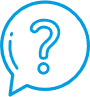
## **¿Preguntas?**

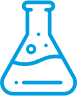
## **Lab 3**